In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

from tqdm import tqdm

import importlib

import sys
import os
sys.path.append(os.path.realpath(".."))
import tools
import ef_tools

Using TensorFlow backend.


In [2]:
import importlib
importlib.reload(ef_tools)
################################################################################

# load data
if False: #os.path.exists("X.npy"):
    X = np.load("X.npy", allow_pickle=True)
    y = np.load("y.npy", allow_pickle=True)
else:
    X, y = ef_tools.open_file("/home/callum/Documents/bbb/user.jagrundy.20736236._000001.MiniNTuple.root", njets=10)
    np.save("X.npy", X, allow_pickle=True)
    np.save("y.npy", y, allow_pickle=True)

# load data
#X, y = qg_jets.load(train + val + test)

# convert labels to categorical
Y=y
#Y = to_categorical(y, num_classes=2)
print(Y.shape)
print('Loaded jets')

padding arrays
done padding
777150 events total
444528 events after ensuring first 3 are correctly tagged
440645 events after ensuring we only have 3 tags
435661 events after ensuring there is at most 1 untagged jet
(435661, 11)
Loaded jets


In [3]:
print(X.shape)

(435661, 10, 4)


In [4]:
# preprocess by centering jets and normalizing pts
for x in tqdm(X):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

print('Finished preprocessing')

100%|██████████| 435661/435661 [00:43<00:00, 10082.14it/s]Finished preprocessing



In [5]:
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 0.7, 0.2, 0.1
# train, val, test = 1000000, 200000, 200000

# network architecture parameters
Phi_sizes, F_sizes = (700, 500, 300, 100), (700, 500, 400, 100)

# network training parameters
num_epoch = 50
batch_size = 500

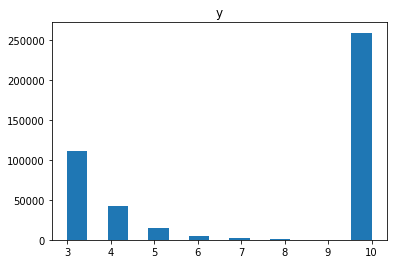

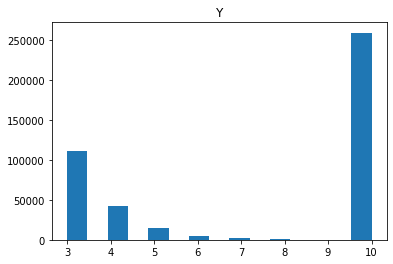

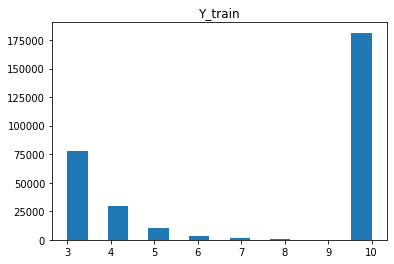

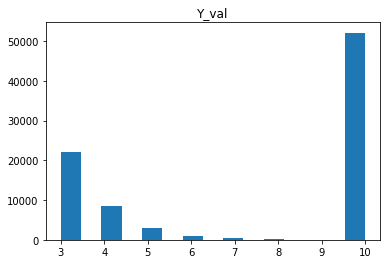

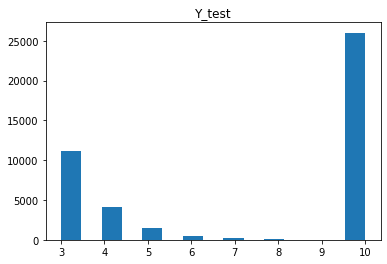

Done train/val/test split
Model summary:
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 700)    3500        input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 700)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 500)    350500      activation_1[0][0]               
___________________________________________________

In [6]:
input_dim = X.shape[2]  # parameters per jet

Y = y[:,3:]  # chop off first 3 jets which are always 1

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

plt.title("y")
plt.hist(y.argmax(axis=1), bins=15)
plt.show()
plt.title("Y")
plt.hist(Y.argmax(axis=1)+3, bins=15)
plt.show()
plt.title("Y_train")
plt.hist(Y_train.argmax(axis=1)+3, bins=15)
plt.show()
plt.title("Y_val")
plt.hist(Y_val.argmax(axis=1)+3, bins=15)
plt.show()
plt.title("Y_test")
plt.hist(Y_test.argmax(axis=1)+3, bins=15)
plt.show()

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=input_dim, output_dim=Y.shape[1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, Phi_l2_regs=0.01, F_l2_regs=0.01)

In [7]:
# train model
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

Train on 304963 samples, validate on 87132 samples
Epoch 1/50
304963/304963 [==============================] - 83s 272us/step - loss: 26.2459 - acc: 0.6180 - val_loss: 10.5312 - val_acc: 0.6589
Epoch 2/50
304963/304963 [==============================] - 89s 292us/step - loss: 5.9293 - acc: 0.6441 - val_loss: 3.1345 - val_acc: 0.6306
Epoch 3/50
304963/304963 [==============================] - 86s 283us/step - loss: 2.1401 - acc: 0.6394 - val_loss: 1.5259 - val_acc: 0.6558
Epoch 4/50
304963/304963 [==============================] - 87s 284us/step - loss: 1.3058 - acc: 0.6387 - val_loss: 1.1465 - val_acc: 0.6560
Epoch 5/50
304963/304963 [==============================] - 88s 287us/step - loss: 1.0989 - acc: 0.6408 - val_loss: 1.0605 - val_acc: 0.6221
Epoch 6/50
304963/304963 [==============================] - 86s 283us/step - loss: 1.0354 - acc: 0.6401 - val_loss: 1.0053 - val_acc: 0.6478
Epoch 7/50
304963/304963 [==============================] - 87s 284us/step - loss: 1.0078 - acc: 0.64

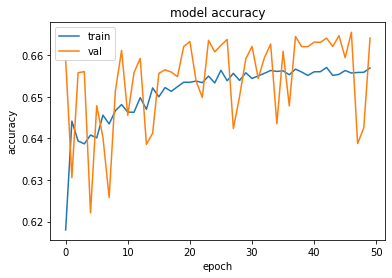

In [8]:
plt.plot(pfn.model.history.history['acc'])
plt.plot(pfn.model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:

# get predictions on test data
preds = pfn.predict(X_test)


100%|██████████| 43566/43566 [00:00<00:00, 77524.53it/s]
ignoring 0.8217417251985493 percent of 43566 events


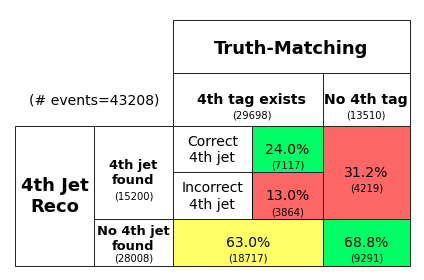

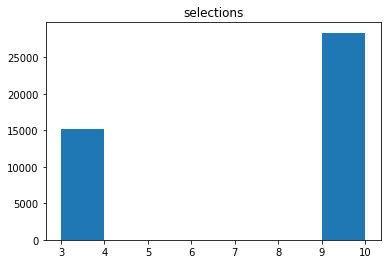

In [12]:
truth = np.concatenate((np.ones((len(Y_test), 3)), Y_test), axis=1)[:,:-1].astype(int)
tag = X_test[:,:,3].astype(int)

preds_max = np.argmax(preds, axis=1) + 3
preds_arr = np.zeros((len(preds), len(preds[0])+3))
for i, p in enumerate(preds_max):
    preds_arr[i][p] = 1
# chop off 'no jet' jet
selections = preds_arr[:,:-1].astype(int)

import importlib
importlib.reload(tools)

print(truth.shape, tag.shape, selections.shape)
tools.evaluate_model(truth, tag, selections)

plt.title("selections")
plt.hist(preds_max, bins=7)
plt.show()
